# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [19]:
data_dir = './data'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

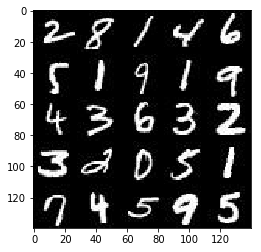

In [20]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import matplotlib

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

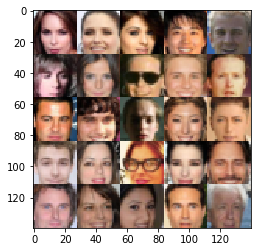

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_input_img = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    z_data = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=None)
    
    return real_input_img, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.01    

    #InvalidArgumentError: Input to reshape is a tensor with 204800 values, but the requested shape requires a multiple of 1152

    with tf.variable_scope("discriminator", reuse=reuse):
        # input is 28*28*3
        print(images.shape)
        conv_1 = tf.layers.conv2d(images, 64, 8, 2, padding="same")
        relu_1 = tf.maximum(alpha * conv_1, conv_1)
        # 14*14*64
        
        conv_2 = tf.layers.conv2d(relu_1, 128, 8, 2, padding="same")
        bn_2 = tf.layers.batch_normalization(conv_2)
        relu_2 = tf.maximum(alpha * bn_2, bn_2)
        # 7*7*128
        
        conv_3 = tf.layers.conv2d(relu_2, 256, 8, 2, padding="same")
        bn_3 = tf.layers.batch_normalization(conv_3)
        relu_3 = tf.maximum(alpha * bn_3, bn_3)      
        # 4*4*256
        
        flat = tf.reshape(relu_3, (-1,4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

(?, 28, 28, 3)
(?, 28, 28, 3)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.01
    reuse = not is_train

    with tf.variable_scope("generator", reuse=reuse):
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4*4*512

        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7*7*256

        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14*14*128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding='same')
        # 28*28*out_channel_dim

        out = tf.tanh(logits)

        return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

(?, 28, 28, 4)
(?, 28, 28, 4)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_input_img, z_data, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input_img, z_data, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={real_input_img: batch_images, z_data:batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={real_input_img: batch_images, z_data:batch_z, lr:learning_rate})
                # not a typo; run the generator one more than discriminator
                _ = sess.run(g_train_opt, feed_dict={real_input_img: batch_images, z_data:batch_z, lr:learning_rate})

                if steps % 100 == 0:
                    train_loss_d = d_loss.eval({z_data:batch_z, real_input_img: batch_images})
                    train_loss_g = g_loss.eval({z_data:batch_z})
                    print("Epoch {}/{} Step {}...".format(epoch_i+1, epoch_count, steps),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))    

                if steps % 200 == 0:
                    show_generator_output(sess, 25, z_data, data_shape[3], data_image_mode)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(?, 28, 28, 1)
(?, 28, 28, 1)
Epoch 1/2 Step 100... Discriminator Loss: 1.4307... Generator Loss: 0.7096
Epoch 1/2 Step 200... Discriminator Loss: 1.4125... Generator Loss: 0.5473


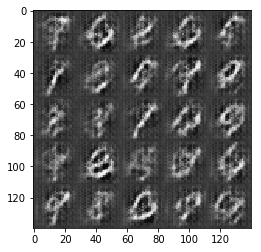

Epoch 1/2 Step 300... Discriminator Loss: 1.3902... Generator Loss: 0.6446
Epoch 1/2 Step 400... Discriminator Loss: 1.8549... Generator Loss: 0.2348


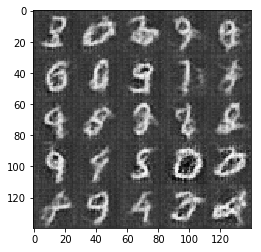

Epoch 1/2 Step 500... Discriminator Loss: 1.3802... Generator Loss: 0.6655
Epoch 1/2 Step 600... Discriminator Loss: 1.2345... Generator Loss: 0.7754


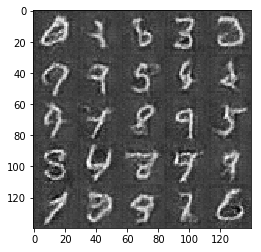

Epoch 1/2 Step 700... Discriminator Loss: 1.1872... Generator Loss: 0.7951
Epoch 1/2 Step 800... Discriminator Loss: 1.0946... Generator Loss: 0.7121


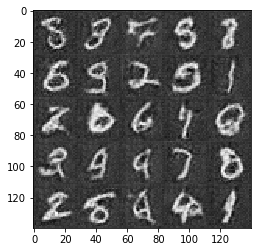

Epoch 1/2 Step 900... Discriminator Loss: 0.9464... Generator Loss: 1.2825
Epoch 1/2 Step 1000... Discriminator Loss: 1.1948... Generator Loss: 0.8712


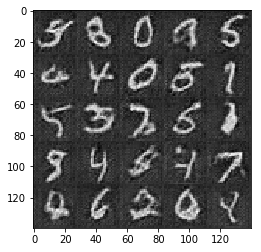

Epoch 1/2 Step 1100... Discriminator Loss: 1.1459... Generator Loss: 0.6780
Epoch 1/2 Step 1200... Discriminator Loss: 1.1784... Generator Loss: 0.5076


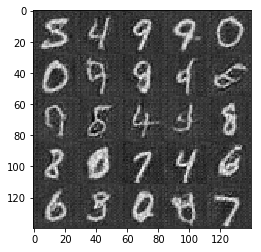

Epoch 1/2 Step 1300... Discriminator Loss: 1.1056... Generator Loss: 0.6647
Epoch 1/2 Step 1400... Discriminator Loss: 1.1320... Generator Loss: 0.7125


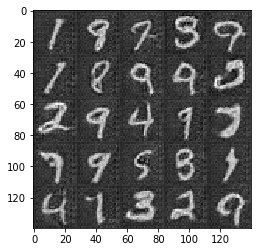

Epoch 1/2 Step 1500... Discriminator Loss: 1.3822... Generator Loss: 0.4765
Epoch 1/2 Step 1600... Discriminator Loss: 1.0975... Generator Loss: 0.9785


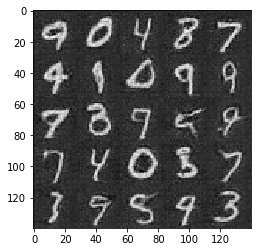

Epoch 1/2 Step 1700... Discriminator Loss: 1.1619... Generator Loss: 0.6231
Epoch 1/2 Step 1800... Discriminator Loss: 0.7198... Generator Loss: 1.9677


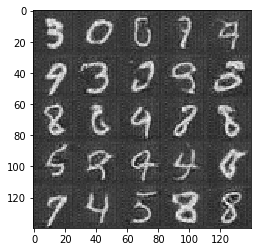

Epoch 2/2 Step 1900... Discriminator Loss: 1.2041... Generator Loss: 0.5763
Epoch 2/2 Step 2000... Discriminator Loss: 1.3190... Generator Loss: 0.4606


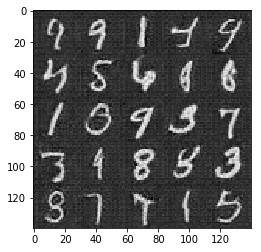

Epoch 2/2 Step 2100... Discriminator Loss: 1.0420... Generator Loss: 0.7850
Epoch 2/2 Step 2200... Discriminator Loss: 1.1153... Generator Loss: 0.7265


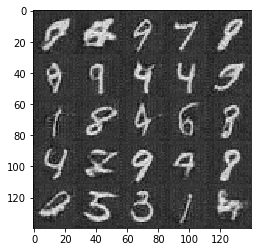

Epoch 2/2 Step 2300... Discriminator Loss: 1.1481... Generator Loss: 0.6233
Epoch 2/2 Step 2400... Discriminator Loss: 0.9899... Generator Loss: 1.0799


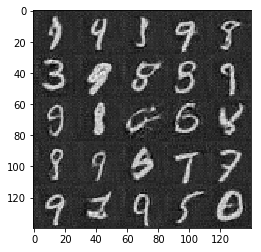

Epoch 2/2 Step 2500... Discriminator Loss: 1.0810... Generator Loss: 0.7009
Epoch 2/2 Step 2600... Discriminator Loss: 1.0495... Generator Loss: 0.7758


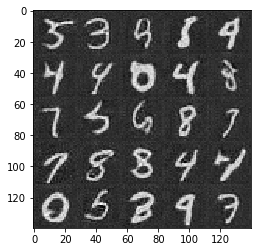

Epoch 2/2 Step 2700... Discriminator Loss: 1.2834... Generator Loss: 0.4547
Epoch 2/2 Step 2800... Discriminator Loss: 1.0500... Generator Loss: 0.8588


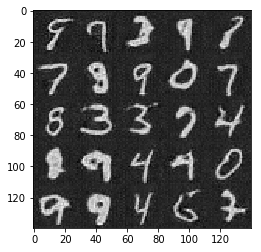

Epoch 2/2 Step 2900... Discriminator Loss: 1.0046... Generator Loss: 0.9155
Epoch 2/2 Step 3000... Discriminator Loss: 0.8248... Generator Loss: 0.9488


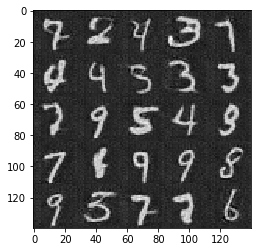

Epoch 2/2 Step 3100... Discriminator Loss: 0.9277... Generator Loss: 0.8057
Epoch 2/2 Step 3200... Discriminator Loss: 0.9795... Generator Loss: 1.0345


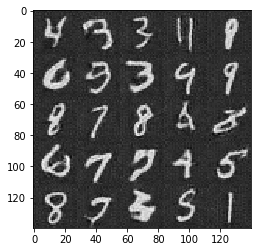

Epoch 2/2 Step 3300... Discriminator Loss: 1.0978... Generator Loss: 0.6510
Epoch 2/2 Step 3400... Discriminator Loss: 1.1369... Generator Loss: 0.6197


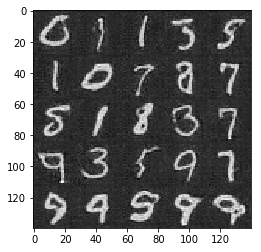

Epoch 2/2 Step 3500... Discriminator Loss: 1.1142... Generator Loss: 0.6259
Epoch 2/2 Step 3600... Discriminator Loss: 1.0611... Generator Loss: 1.0180


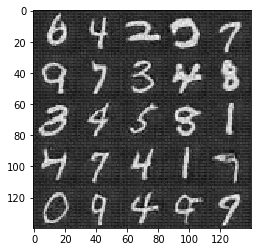

Epoch 2/2 Step 3700... Discriminator Loss: 1.1245... Generator Loss: 0.6226


In [25]:
batch_size = 32
z_dim = 64
learning_rate = 0.0004
beta1 = 0.4

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(?, 28, 28, 3)
(?, 28, 28, 3)
Epoch 1/1 Step 100... Discriminator Loss: 1.0546... Generator Loss: 0.9429
Epoch 1/1 Step 200... Discriminator Loss: 1.3776... Generator Loss: 0.6087


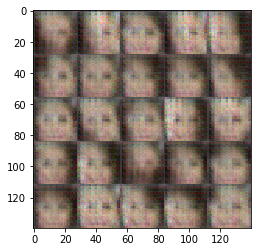

Epoch 1/1 Step 300... Discriminator Loss: 1.3402... Generator Loss: 0.8284
Epoch 1/1 Step 400... Discriminator Loss: 1.3478... Generator Loss: 0.6448


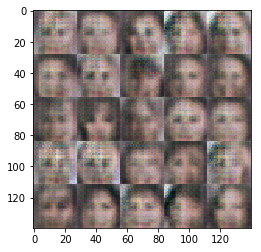

Epoch 1/1 Step 500... Discriminator Loss: 1.3686... Generator Loss: 0.6802
Epoch 1/1 Step 600... Discriminator Loss: 1.3886... Generator Loss: 0.7138


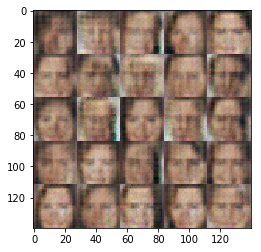

Epoch 1/1 Step 700... Discriminator Loss: 1.3732... Generator Loss: 0.6889
Epoch 1/1 Step 800... Discriminator Loss: 1.3944... Generator Loss: 0.6495


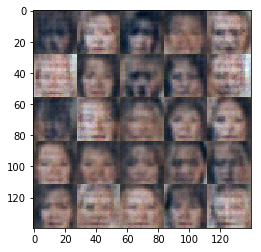

Epoch 1/1 Step 900... Discriminator Loss: 1.3717... Generator Loss: 0.7180
Epoch 1/1 Step 1000... Discriminator Loss: 1.4214... Generator Loss: 0.6568


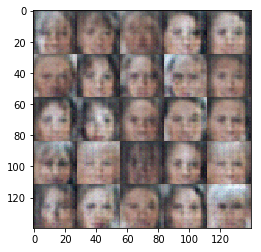

Epoch 1/1 Step 1100... Discriminator Loss: 1.3917... Generator Loss: 0.6727
Epoch 1/1 Step 1200... Discriminator Loss: 1.3829... Generator Loss: 0.6583


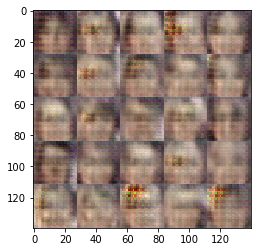

Epoch 1/1 Step 1300... Discriminator Loss: 1.3931... Generator Loss: 0.6794
Epoch 1/1 Step 1400... Discriminator Loss: 1.4064... Generator Loss: 0.6560


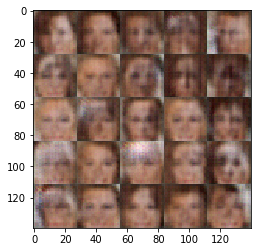

Epoch 1/1 Step 1500... Discriminator Loss: 1.4144... Generator Loss: 0.6351
Epoch 1/1 Step 1600... Discriminator Loss: 1.3832... Generator Loss: 0.6916


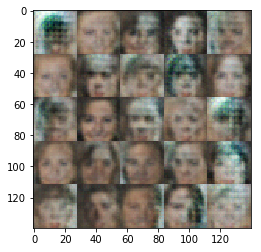

Epoch 1/1 Step 1700... Discriminator Loss: 1.3721... Generator Loss: 0.6765
Epoch 1/1 Step 1800... Discriminator Loss: 1.3889... Generator Loss: 0.7018


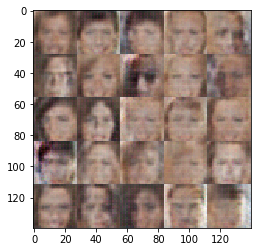

Epoch 1/1 Step 1900... Discriminator Loss: 1.3669... Generator Loss: 0.6845
Epoch 1/1 Step 2000... Discriminator Loss: 1.3973... Generator Loss: 0.6888


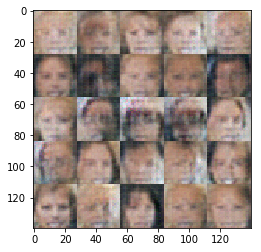

Epoch 1/1 Step 2100... Discriminator Loss: 1.4196... Generator Loss: 0.6475
Epoch 1/1 Step 2200... Discriminator Loss: 1.4097... Generator Loss: 0.6609


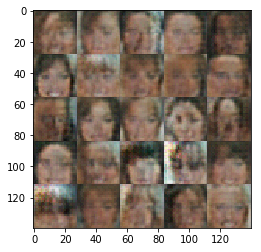

Epoch 1/1 Step 2300... Discriminator Loss: 1.4273... Generator Loss: 0.6418
Epoch 1/1 Step 2400... Discriminator Loss: 1.3706... Generator Loss: 0.6999


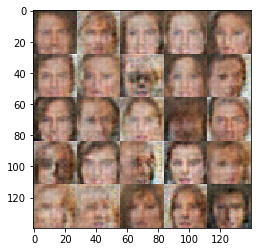

Epoch 1/1 Step 2500... Discriminator Loss: 1.3922... Generator Loss: 0.6902
Epoch 1/1 Step 2600... Discriminator Loss: 1.4050... Generator Loss: 0.6383


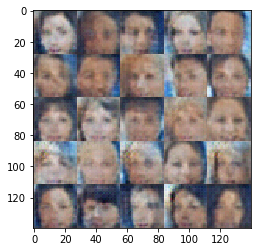

Epoch 1/1 Step 2700... Discriminator Loss: 1.3914... Generator Loss: 0.6714
Epoch 1/1 Step 2800... Discriminator Loss: 1.4004... Generator Loss: 0.6592


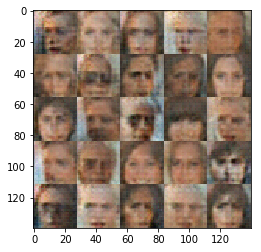

Epoch 1/1 Step 2900... Discriminator Loss: 1.4007... Generator Loss: 0.6762
Epoch 1/1 Step 3000... Discriminator Loss: 2.0416... Generator Loss: 0.2643


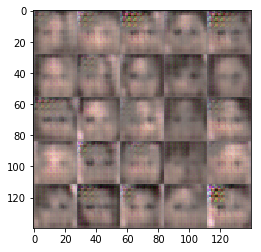

Epoch 1/1 Step 3100... Discriminator Loss: 1.3872... Generator Loss: 0.6574
Epoch 1/1 Step 3200... Discriminator Loss: 1.3667... Generator Loss: 0.7081


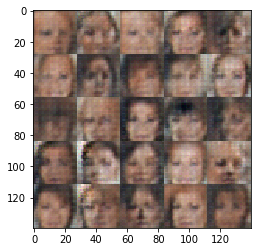

Epoch 1/1 Step 3300... Discriminator Loss: 1.3425... Generator Loss: 0.7063
Epoch 1/1 Step 3400... Discriminator Loss: 1.4224... Generator Loss: 0.5801


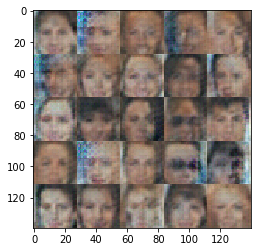

Epoch 1/1 Step 3500... Discriminator Loss: 1.3254... Generator Loss: 0.7116
Epoch 1/1 Step 3600... Discriminator Loss: 1.4063... Generator Loss: 0.6917


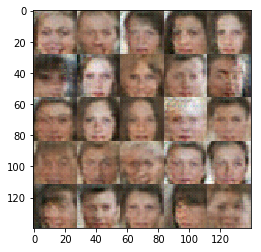

Epoch 1/1 Step 3700... Discriminator Loss: 1.4470... Generator Loss: 0.6195
Epoch 1/1 Step 3800... Discriminator Loss: 1.3638... Generator Loss: 0.6801


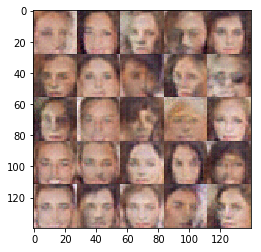

Epoch 1/1 Step 3900... Discriminator Loss: 1.4838... Generator Loss: 0.6562
Epoch 1/1 Step 4000... Discriminator Loss: 1.3543... Generator Loss: 0.6683


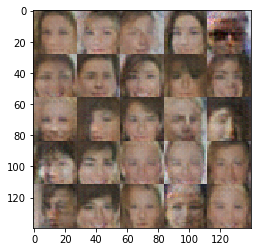

Epoch 1/1 Step 4100... Discriminator Loss: 1.3923... Generator Loss: 0.6567
Epoch 1/1 Step 4200... Discriminator Loss: 1.4203... Generator Loss: 0.6612


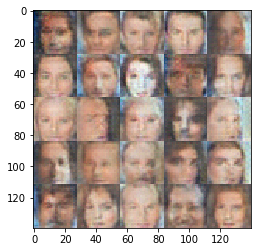

Epoch 1/1 Step 4300... Discriminator Loss: 1.5511... Generator Loss: 0.5750
Epoch 1/1 Step 4400... Discriminator Loss: 1.4469... Generator Loss: 0.6411


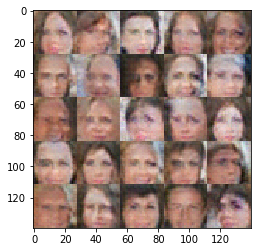

Epoch 1/1 Step 4500... Discriminator Loss: 1.5399... Generator Loss: 0.5938
Epoch 1/1 Step 4600... Discriminator Loss: 1.4458... Generator Loss: 0.5798


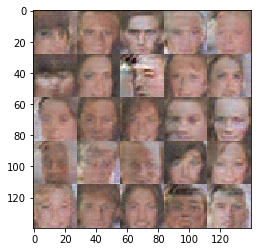

Epoch 1/1 Step 4700... Discriminator Loss: 1.4637... Generator Loss: 0.5902
Epoch 1/1 Step 4800... Discriminator Loss: 1.4366... Generator Loss: 0.6157


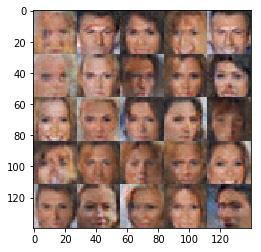

Epoch 1/1 Step 4900... Discriminator Loss: 1.4574... Generator Loss: 0.6367
Epoch 1/1 Step 5000... Discriminator Loss: 1.4073... Generator Loss: 0.6351


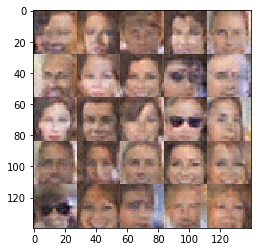

Epoch 1/1 Step 5100... Discriminator Loss: 1.4080... Generator Loss: 0.6377
Epoch 1/1 Step 5200... Discriminator Loss: 1.4186... Generator Loss: 0.6602


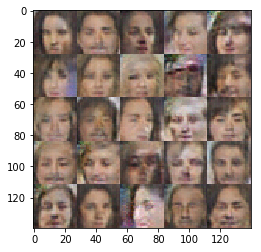

Epoch 1/1 Step 5300... Discriminator Loss: 1.3798... Generator Loss: 0.7100
Epoch 1/1 Step 5400... Discriminator Loss: 1.6218... Generator Loss: 0.5117


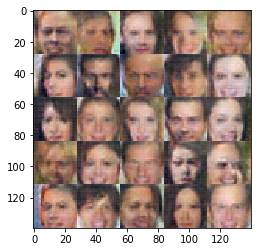

Epoch 1/1 Step 5500... Discriminator Loss: 1.3640... Generator Loss: 0.6375
Epoch 1/1 Step 5600... Discriminator Loss: 1.3654... Generator Loss: 0.6543


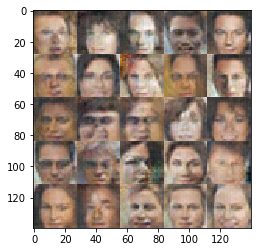

Epoch 1/1 Step 5700... Discriminator Loss: 1.3844... Generator Loss: 0.6426
Epoch 1/1 Step 5800... Discriminator Loss: 1.4180... Generator Loss: 0.5774


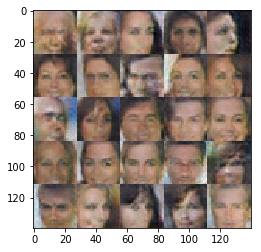

Epoch 1/1 Step 5900... Discriminator Loss: 1.5659... Generator Loss: 0.5190
Epoch 1/1 Step 6000... Discriminator Loss: 1.3922... Generator Loss: 0.6188


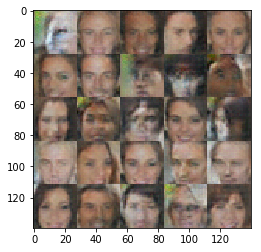

Epoch 1/1 Step 6100... Discriminator Loss: 1.5941... Generator Loss: 0.6167
Epoch 1/1 Step 6200... Discriminator Loss: 1.4378... Generator Loss: 0.6289


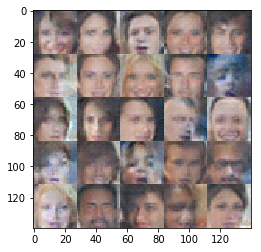

Epoch 1/1 Step 6300... Discriminator Loss: 1.5925... Generator Loss: 0.6237
CPU times: user 16min 55s, sys: 2min 49s, total: 19min 45s
Wall time: 30min 52s


In [21]:
%%time
""" Reviewer Notes:
Learning Rate: Appropriate values are 0.0002 - 0.0008
Beta1: Appropriate values are 0.4 - 0.5
Alpha/leak parameter: Appropriate values are 0.1 - 0.2
Z-dim: Appropriate values are 100 - 128
Batch Size: Appropriate batch sizes are 32 - 64

TIPS:
Learning rate and Beta1(The exponential decay rate for the 1st-moment estimates) are inverses of each other. When increasing the learning rate, Beta1 should also decrease, and vice versa for stability purposes. You can learn more about momentum in gradient descent algorithms in this link and Adam in this link

Always set parameters in powers of 2 like 4,8,16,32,64..... This will help TensorFlow to optimize the computation.
"""

batch_size = 32
z_dim = 128
learning_rate = 0.0006
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.